In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure as measure
import skimage.io as io
import pandas as pd
import math
import skimage.transform as transform

In [2]:
os.getcwd() # check workinh directory
# Constants
GFP_path = 'data/gfp_rscl.tif'
mCherry_path = 'data/mcy_rscl.tif'
MASK_path = 'data/P1_Mask.tif'
DIC_path = 'data/P1_DIC.tif'

In [3]:
# All input dimension should be (FRAME_NUMBER, 1200, 1200)
mask = io.imread(MASK_path)
gfp = io.imread(GFP_path)
mcy = io.imread(mCherry_path)
dic = io.imread(DIC_path)
print(np.shape(mask), np.shape(gfp), np.shape(mcy)) # check dimention
frame_num = np.shape(mask)[0] # get time-lapse length

(289, 1200, 1200) (289, 1200, 1200) (289, 1200, 1200)


In [33]:
# Example: Measure intensity of each object in frame 1
gfp_frame = measure.regionprops(
    measure.label(mask[1,:,:]),
    intensity_image = gfp[1,:,:])
mcy_frame = measure.regionprops(
    measure.label(mask[1,:,:]),
    intensity_image = mcy[1,:,:])
# Reference: https://blog.csdn.net/u013066730/article/details/87971770
i = 0
j = 1
bbox_obj = gfp_frame[i].bbox
bbox.append(bbox_obj)
gfp_obj = np.multiply(gfp[j, bbox_obj[0]:bbox_obj[2], bbox_obj[1]:bbox_obj[3]], gfp_frame[i].image)
mcy_obj = np.multiply(mcy[j, bbox_obj[0]:bbox_obj[2], bbox_obj[1]:bbox_obj[3]], gfp_frame[i].image)
dic_obj = np.multiply(dic[j, bbox_obj[0]:bbox_obj[2], bbox_obj[1]:bbox_obj[3]], gfp_frame[i].image)
stack = np.stack([dic_obj, gfp_obj, mcy_obj], axis=2)
stack_resized = transform.resize(stack, (80,80,3))

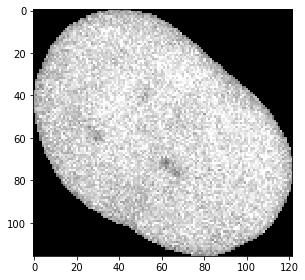

In [34]:
io.imshow(gfp_obj)

In [6]:
# Measure intensity of all objects in dataset
x = []
y = []
frame = []
gfp_intensity = []
mcy_intensity = []
bbox = []
stacks = []
area = []
for j in range(frame_num):
    # for each time frame
    gfp_frame = measure.regionprops(
        measure.label(mask[j,:,:]),
        intensity_image = gfp[j,:,:])
    mcy_frame = measure.regionprops(
        measure.label(mask[j,:,:]),
        intensity_image = mcy[j,:,:])
    for i in range(len(gfp_frame)):
        mask_current = np.zeros((1200,1200))
        if gfp_frame[i].area > 1000:
            # initial size filter: more than 1000 excluded.
            # for each object in the time frame
            gfp_intensity.append(gfp_frame[i].mean_intensity)
            mcy_intensity.append(mcy_frame[i].mean_intensity)
            area.append(gfp_frame[i].area)
            
            bbox_obj = gfp_frame[i].bbox
            bbox.append(bbox_obj)
            gfp_obj = np.multiply(gfp[j, bbox_obj[0]:bbox_obj[2], bbox_obj[1]:bbox_obj[3]], gfp_frame[i].image)
            mcy_obj = np.multiply(mcy[j, bbox_obj[0]:bbox_obj[2], bbox_obj[1]:bbox_obj[3]], gfp_frame[i].image)
            dic_obj = np.multiply(dic[j, bbox_obj[0]:bbox_obj[2], bbox_obj[1]:bbox_obj[3]], gfp_frame[i].image)
            stack = np.stack([dic_obj, gfp_obj, mcy_obj], axis=2)
            stack_resized = transform.resize(stack, (80,80,3))
            stacks.append(stack_resized)
            
            frame.append(j)
            x.append(math.ceil(gfp_frame[i].centroid[0]))
            y.append(math.ceil(gfp_frame[i].centroid[1]))
            
dt = pd.DataFrame({"id":[x for x in range(1,len(x)+1)],"x":x,"y":y,"frame":frame,"gfp_intensity":gfp_intensity,"mcy_intensity":mcy_intensity,
                  "bbox":bbox,"area":area, "imageResized":stacks})

In [7]:
# ***optional***
# Training set reference table, no use when performing analysis.
ref = pd.read_csv('data/training/cls.csv')
ref['Center of the object_0'] = list(map(math.ceil, list(ref['Center of the object_0']))) # correct coordinate difference
ref['Center of the object_1'] = list(map(math.ceil, list(ref['Center of the object_1'])))
ref.rename(columns={'Center of the object_1':'x', 'Center of the object_0':'y'},inplace=True)
ref = ref[['frame','User Label','x','y']] # select useful columns
dt_label = pd.merge(dt, ref, on=('frame','x','y'))
dt_label = dt_label.sort_values(by="id")

In [21]:
# ***optional***
# Output training set
for i in range(dt_label.shape[0]):
    id = dt_label.iloc[i,0] # id
    label = dt_label.iloc[i,9] # user label
    image = dt_label.iloc[i,8] # image
    io.imsave('data/training/train/train_'+str(id)+"_"+label+".tif", image)

In [46]:
# ***optional***
# Store training metadata
dt_label[['id','frame','User Label','x','y']].to_csv('data/intensity.csv')

In [11]:
# ***optional***
# Join table with tracking result
track = pd.read_csv('data/P1_mask-data_CSV-Table.csv') # ilastik tracking output, coordinate difference = 1
track['Center_of_the_object_0'] += 1 # correct coordinate difference
track['Center_of_the_object_1'] += 1
track.rename(columns={'Center_of_the_object_1':'x', 'Center_of_the_object_0':'y'},inplace=True) # rename for inner join
track = track[['frame','trackId','x','y']] # select useful columns
dt = pd.merge(dt, track, on=('frame','x','y'))

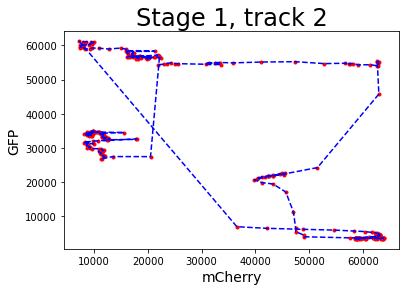

In [70]:
trackId = 2
dt_filtered = dt[dt['trackId']==trackId]
plt.scatter(dt_filtered['mcy_intensity'], dt_filtered['gfp_intensity'], marker=".", color='red')
plt.plot(dt_filtered['mcy_intensity'], dt_filtered['gfp_intensity'], linestyle="dashed", color='blue')
plt.title('Stage 1, track ' + str(trackId), fontsize=24)
plt.xlabel('mCherry', fontsize=14)
plt.ylabel('GFP', fontsize=14)
'''
# bug, add frame label to each point
for i in range(dt_filtered.shape[0]-1):
    plt.text(x=dt_filtered['mcy_intensity'][i], y=dt_filtered['gfp_intensity'][i], s=str(dt_filtered['frame'][i]),
            fontsize=10, color = "r", verticalalignment='center', horizontalalignment='right')
'''
plt.show()

In [21]:
# Filter table according to frame
dt_filtered = dt[dt['frame']==23]

Text(0, 0.5, 'GFP')

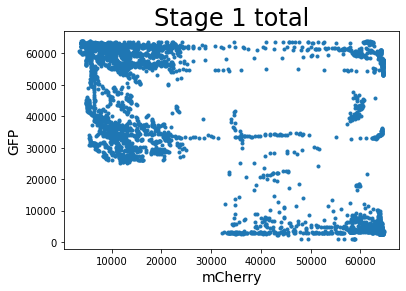

In [23]:
plt.scatter(dt['mcy_intensity'], dt['gfp_intensity'], marker=".")
plt.title('Stage 1 total', fontsize=24)
plt.xlabel('mCherry', fontsize=14)
plt.ylabel('GFP', fontsize=14)

## TO DO

In [44]:
cls = pd.read_csv("/Users/jefft/Desktop/BMI_Project/test2-data_table.csv")

In [45]:
cls = cls[['User Label','Center of the object_1', 'Center of the object_0', 'Size in pixels','timestep']]
cls['Center of the object_1'] = list(map(math.ceil, cls['Center of the object_1']))
cls['Center of the object_0'] = list(map(math.ceil, cls['Center of the object_0']))
cls.rename(columns={'Center of the object_1':'x', 'Center of the object_0':'y', 'timestep':'frame'}, inplace=True)

In [46]:
cls_dt_merged = pd.merge(cls, dt, "inner")

Text(0, 0.5, 'GFP')

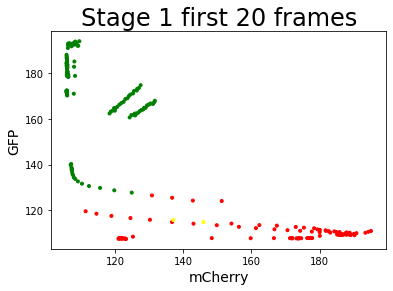

In [66]:
cls_dt_merged = cls_dt_merged[cls_dt_merged['User Label']!="F"]
color = []
for i in range(cls_dt_merged.shape[0]):
    l = cls_dt_merged.iloc[i,0]
    if l=="S":
        color.append('green')
    elif l=="G1":
        color.append('red')
    else:
        color.append('yellow')
plt.scatter(cls_dt_merged['mcy_intensity'], cls_dt_merged['gfp_intensity'], marker=".", label="User Label", c=color)
plt.title('Stage 1 first 20 frames', fontsize=24)
plt.xlabel('mCherry', fontsize=14)
plt.ylabel('GFP', fontsize=14)

In [39]:
del(mask)